In [146]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from itertools import product
from scipy.stats import qmc  # For Latin Hypercube Sampling
import torch
import gpytorch
import random
from PIL import Image
from datetime import datetime
import scienceplots
# plt.style.available
# plt.style.use(['science', 'notebook'])

In [147]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, meanPrior):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        if meanPrior == 'max':
            # self.mean_module = gpytorch.means.ZeroMean()
            self.mean_module = gpytorch.means.ConstantMean()
            # self.mean_module.constant = torch.nn.Parameter(torch.tensor(torch.max(train_y)))
            self.mean_module.constant.data = torch.tensor(torch.max(train_y))

        else:
            # self.mean_module = gpytorch.means.ConstantMean(constant_prior=torch.max(train_y))
            self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
def GPTrain(features, targets, meanPrior):

    tensorSamplesXY = torch.from_numpy(features)
    tensorSamplesZ = torch.from_numpy(targets)

    likelihood = gpytorch.likelihoods.GaussianLikelihood() 
    model = ExactGPModel(tensorSamplesXY, tensorSamplesZ, likelihood, meanPrior)
    likelihood.noise = 1e-4
    likelihood.noise_covar.raw_noise.requires_grad_(False)

    training_iter = 250
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(tensorSamplesXY)
        # Calc loss and backprop gradients
        loss = -mll(output, tensorSamplesZ)
        loss.backward()
        # print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #     i + 1, training_iter, loss.item(),
        #     model.covar_module.base_kernel.lengthscale.item(), #.kernels[0] after base_kernel if have multiple kernels
        #     model.likelihood.noise.item()
        # ))
        optimizer.step()
    
    return model


def GPEval(model, newFeatures):
    model.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = model(torch.from_numpy(newFeatures))

    mean_pred = observed_pred.mean.numpy()

    return mean_pred

In [148]:
class DifferentialEvolution:
    def __init__(self, bounds, objective_function, pop_size=50, mutation_factor=0.8, crossover_prob=0.7, max_generations=200, method='random'):
        """
        Initialize the Differential Evolution (DE) optimizer.
        
        Parameters:
        bounds (list of tuple): List of (min, max) bounds for each dimension.
        pop_size (int): Number of candidate solutions in the population.
        mutation_factor (float): Scaling factor for mutation [0, 2].
        crossover_prob (float): Crossover probability [0, 1].
        max_generations (int): Maximum number of generations to evolve.
        method (str): Population initialization method ('random' or 'lhs').
        """
        self.bounds = np.array(bounds)
        self.dimensions = len(bounds)
        self.pop_size = pop_size
        self.mutation_factor = mutation_factor
        self.crossover_prob = crossover_prob
        self.max_generations = max_generations
        self.method = method
        
        # Initialize population
        self.population = self.initialize_population()
        self.best_solution = None
        self.best_fitness = np.inf
        self.objective_function = objective_function
    
    def initialize_population(self):
        """Initialize population using random sampling or Latin Hypercube Sampling."""
        if self.method == 'lhs':
            # Latin Hypercube Sampling
            sampler = qmc.LatinHypercube(d=self.dimensions)
            sample = sampler.random(n=self.pop_size)
            population = qmc.scale(sample, self.bounds[:, 0], self.bounds[:, 1])
        else:
            # Random Sampling
            population = np.random.rand(self.pop_size, self.dimensions)
            for i in range(self.dimensions):
                population[:, i] = self.bounds[i, 0] + population[:, i] * (self.bounds[i, 1] - self.bounds[i, 0])
        
        # print(population.shape)
        return population
    
    def mutate(self, target_idx):
        """Mutation using DE/best/1 strategy."""
        # Choose three random and distinct individuals different from target_idx
        indices = [idx for idx in range(self.pop_size) if idx != target_idx]
        np.random.shuffle(indices)
        r1, r2 , r3= indices[:3]
        
        # Best individual in current population

        # print(self.population.shape)

        #TODO  instead of this list comprehension bollocks just evaluate them all at once
        #as thats what i think it wants, then find the minimum of the results. 


        predictedValues = GPEval(self.objective_function, self.population)

        best_idx = np.argsort(predictedValues)[:1]

        best = self.population[best_idx]

        # best_idx = np.argmin([self.objective_function.predict(ind) for ind in self.population])
        # best = self.population[best_idx]
        
        # Mutant vector: v = best + F * (r1 - r2)
        mutant = best + self.mutation_factor * (self.population[r1] - self.population[r2])
        
        # Ensure mutant vector is within bounds
        mutant = np.clip(mutant, self.bounds[:, 0], self.bounds[:, 1])
        
        return mutant
    
    def crossover(self, target, mutant):
        """Crossover to create trial vector."""
        trial = np.copy(target)
        # print(trial.shape)
        # print(mutant.shape)
        for i in range(self.dimensions):
            if np.random.rand() < self.crossover_prob or i == np.random.randint(self.dimensions):
                # print(trial[i], mutant[i])
                trial[i] = mutant[i]
        return trial
    
    def select(self, target, trial):
        """Selection: Return the individual with the better fitness."""
        if self.objective_function.predict(trial) < self.objective_function.predict(target):
            return trial
        return target

    def select(self, target, trial):
        """Selection: Return the individual with the better fitness."""
        if GPEval(self.objective_function, trial) < GPEval(self.objective_function, target):
            return trial
        return target
    
    def optimize(self):
        """Run the Differential Evolution optimization."""
        # x_range = np.linspace(-5, 5, 100)
        # y_range = np.linspace(-5, 5, 100)
        # X, Y = np.meshgrid(x_range, y_range)
        # Z = ackley_function(X, Y)
        x_range = np.linspace(self.bounds[0,0], self.bounds[0,1],50)
        y_range = np.linspace(self.bounds[1,0], self.bounds[1,1],50)
        fullRange = list(product(x_range, y_range))
        fullRangeArray = np.array(fullRange)
        # y_pred = self.objective_function.predict(fullRangeArray)
        y_pred = GPEval(self.objective_function, fullRangeArray)

        for generation in range(self.max_generations):
            new_population = np.zeros_like(self.population)
            allTrials = np.zeros_like(self.population)
            allTargets = np.zeros_like(self.population)
            # print(self.population.shape)
            for i in range(self.pop_size):
                target = self.population[i]
                # print('break')
                # print(i)
                mutant = self.mutate(i)
                # print(mutant)
                mutant = np.reshape(mutant, (2,))
                # print(mutant)
                trial = self.crossover(target, mutant)
                trial = np.reshape(trial, (1,-1))
                target = np.reshape(target, (1,-1))
                # print('for select', trial.shape, target.shape)
                new_population[i] = self.select(target, trial)
            
            # Update the population
            self.population = new_population
            
            # Track the best solution
            # best_idx = np.argmin([self.objective_function.predict(ind) for ind in self.population])
            # best_fitness = self.objective_function.predict(self.population[best_idx])
            
            # predictedValues = self.objective_function.predict(self.population)
            predictedValues = GPEval(self.objective_function, self.population)

            best_idx = np.argsort(predictedValues)[:1]

            # best_fitness = self.objective_function.predict(self.population[best_idx])
            best_fitness = GPEval(self.objective_function, self.population[best_idx])

            if best_fitness < self.best_fitness:
                self.best_fitness = best_fitness
                self.best_solution = self.population[best_idx]
            
            # plt.contourf(x_range, y_range, y_pred, levels=50, cmap='viridis')
        plt.scatter(fullRangeArray[:,0], fullRangeArray[:,1], c = y_pred)

        plt.scatter(self.population[:, 0], self.population[:, 1], color='red', label='Final Population', s=5)
        # plt.scatter(best_solution[0], best_solution[1], color='blue', label='Best Solution', s=100)
        # plt.legend()
        plt.title("Local Surrogate")
        plt.colorbar()
        plt.clim(0,14)
        plt.xlim(self.bounds[0,0], self.bounds[0,1])
        plt.ylim(self.bounds[1,0], self.bounds[1,1])
        # plt.savefig('localGP.png')
        plt.show()
        # # Debug information
        print(f"Generation {generation + 1}: Best RBF Fitness = {self.best_fitness}")
        
        return self.best_solution, self.best_fitness

In [149]:
def ackley_function(x, y, a=20, b=0.2, c=2 * np.pi):
    term1 = -a * np.exp(-b * np.sqrt(0.5 * (x**2 + y**2)))
    term2 = -np.exp(0.5 * (np.cos(c * x) + np.cos(c * y)))
    return term1 + term2 + a + np.exp(1)

def objective_function(vec):
    """Objective function wrapper for optimization.
    Args:
        vec (np.ndarray): A vector representing candidate solution (x, y).
    Returns:
        float: Fitness value of the solution.
    """
    x, y = vec
    return ackley_function(x, y)

In [150]:
class PSOPrescreen:
    def __init__(self, bounds, pop_size, c1=2.05, c2=2.05, PSOFE=50):

        self.globalBounds = np.array(bounds)
        self.dimensions = len(bounds)
        self.pop_size = pop_size
        self.max_generations = PSOFE
        self.feFeatures = np.empty((0,2))
        self.globalBestFeature = np.empty((0,2))
        self.feTargets = np.empty(0) 
        self.globalBestTarget = np.empty(0) 
        self.popBestFeature = np.empty((pop_size, self.dimensions))
        self.popBestTargets = np.empty(0)
        # self.globalBestValue = np.inf
        self.generator = np.random.default_rng()

        self.population = self.initialisePopulation()
        self.velocities = self.initialiseVelocities()

        self.c1 = c1
        self.c2 = c2
        self.phi = c1 + c2
        self.chi = 2/(2 - self.phi - (np.sqrt((self.phi**2) - (4 * self.phi))))


    def initialisePopulation(self):

        sampler = qmc.LatinHypercube(d=self.dimensions)
        sample = sampler.random(n=self.pop_size)
        population = qmc.scale(sample, self.globalBounds[:, 0], self.globalBounds[:, 1])

        for i in range(0, len(population)):
            #need to track every function evaluation for building surrogate models
            #set initial feFeatures and targets to be population and best values
            self.feTargets = np.append(self.feTargets, objective_function(population[i]))
            self.feFeatures = np.vstack((self.feFeatures, population[i]))
            # self.population = self.feFeatures
            self.popBestFeature = self.feFeatures
            self.popBestTargets = self.feTargets

            bestIdx = np.argmin(self.feTargets)
            self.globalBestFeature = self.feFeatures[bestIdx]
            self.globalBestTarget = self.feTargets[bestIdx]


        plt.scatter(self.feFeatures[:,0], self.feFeatures[:,1], c = self.feTargets)
        plt.title('Initial Population')
        plt.colorbar()
        plt.show()

        return population

    def initialiseVelocities(self):
        """Initialize particle velocities as a small fraction of the bounds range."""
        velocity_range = (self.globalBounds[:, 1] - self.globalBounds[:, 0]) * 0.1
        return self.generator.uniform(low=-velocity_range, high=velocity_range, size=(self.pop_size, self.dimensions))
    
    
    

    def updateVelocity(self):

        r1, r2= np.random.random(2)

        self.velocities = self.chi * (self.velocities + (self.c1*r1) * (self.popBestFeature - self.population) +
                                      self.c2*r2 * (self.globalBestFeature - self.population))
        

    def updatePosition(self):

        self.population = self.population + self.velocities


    def clipPositions(self):
        """Clip particle positions to stay within bounds."""
        self.population = np.clip(self.population, self.globalBounds[:, 0], self.globalBounds[:, 1])
    

    def optimise(self):
        iteration=0
        x_range = np.linspace(-5, 5, 100)
        y_range = np.linspace(-5, 5, 100)
        X, Y = np.meshgrid(x_range, y_range)
        Z = ackley_function(X, Y)

        while iteration < self.max_generations:
            #build global model  
            GPModel = GPTrain(self.feFeatures, self.feTargets, meanPrior='zero')
            globalDE = DifferentialEvolution(self.globalBounds, GPModel)
            bestGPSolution, bestGPFitness = globalDE.optimize()

            # print(bestGPSolution, bestGPFitness)
            # bestGPSolution = [bestGPSolution[0], bestGPSolution[1]]
            # print(bestGPSolution.shape)

            bestGPSolution_r = np.reshape(bestGPSolution, (2,1))

            self.feTargets = np.append(self.feTargets, objective_function(bestGPSolution_r))
            self.feFeatures = np.vstack((self.feFeatures, bestGPSolution))

            bestIdx = np.argmin(self.feTargets)
            if self.feTargets[bestIdx] < self.globalBestTarget:
                self.globalBestFeature = self.feFeatures[bestIdx]
                self.globalBestTarget = self.feTargets[bestIdx]
            
            self.updateVelocity()

            self.updatePosition()

            self.clipPositions()


            swarmOnGP = GPEval(GPModel, self.population)

            betterThanPBest = swarmOnGP < self.popBestTargets

            print(betterThanPBest)

            # toEvaluate = self.population[betterThanPBest]
            toEvaluate = np.where(betterThanPBest)[0]

            print(toEvaluate)
            # print(toEvaluate.shape)

            for i in range(0, len(toEvaluate)):

                targetToEval = np.reshape(self.population[toEvaluate[i]], (2,1))

                # objFuncEval = objective_function(self.population[toEvaluate[i]])
                objFuncEval = objective_function(targetToEval)

                self.feTargets = np.append(self.feTargets, objFuncEval)
                self.feFeatures = np.vstack((self.feFeatures, self.population[toEvaluate[i]]))

                if objFuncEval < self.popBestTargets[toEvaluate[i]]:
                    self.popBestTargets[toEvaluate[i]] = objFuncEval
                    self.popBestFeature[toEvaluate[i]] = self.population[toEvaluate[i]]

            iteration+=1

            plt.contourf(X, Y, Z, levels=50, cmap='viridis')
            plt.scatter(self.population[:, 0], self.population[:, 1], color='red', label='Swarm', s=10)
            # plt.scatter(best_solution[0], best_solution[1], color='blue', label='Best Solution', s=100)
            plt.legend()
            plt.title("PSO Optimisation of Ackley Function")
            plt.colorbar()
            # plt.savefig(f'DEPlots/{timestamp}.png')
            plt.clim(0,14)

            plt.show()
            # plt.close()
            # Debug information
            print(f"Iteration {iteration + 1}: Best Fitness = {self.globalBestTarget}")





    

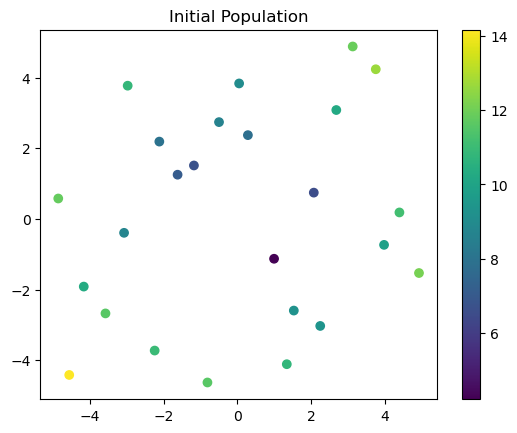

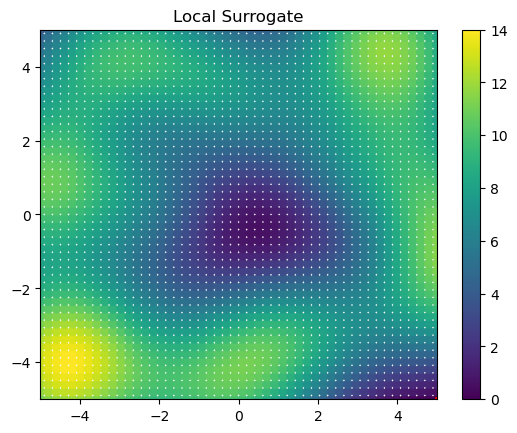

Generation 200: Best RBF Fitness = [2.6512563]
[ True False False False False  True  True  True  True  True False  True
  True  True False False False False  True False False False  True  True
  True]
[ 0  5  6  7  8  9 11 12 13 18 22 23 24]


/var/folders/8p/wlgb17ln00dg_lln7zq_3gpw0000gn/T/ipykernel_2106/690438555.py:136: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.popBestTargets[toEvaluate[i]] = objFuncEval


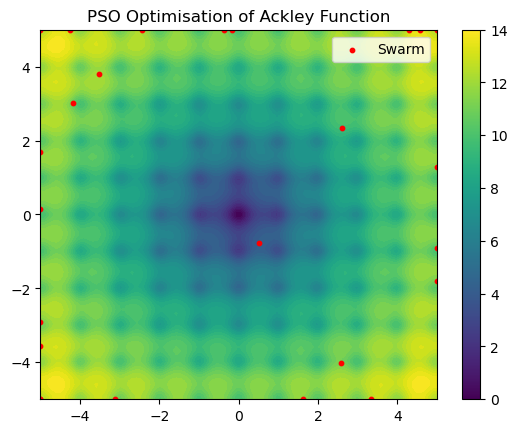

Iteration 2: Best Fitness = 4.219309861732029


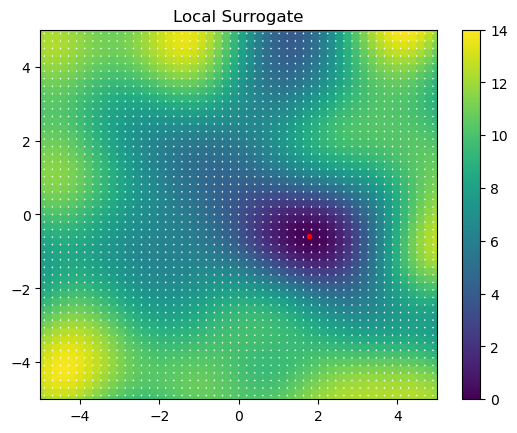

Generation 200: Best RBF Fitness = [2.17957355]
[False False False False False False  True  True False False False False
  True False False False False False  True False False False  True False
 False]
[ 6  7 12 18 22]


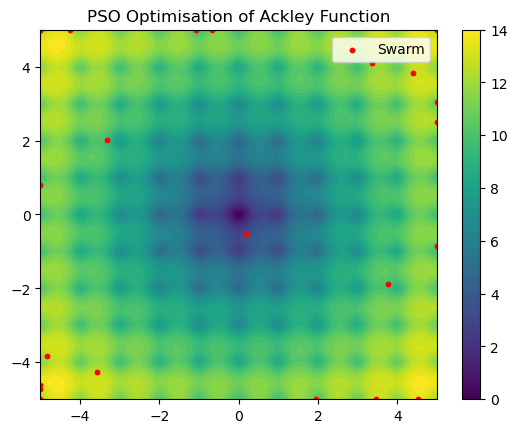

Iteration 3: Best Fitness = 4.219309861732029


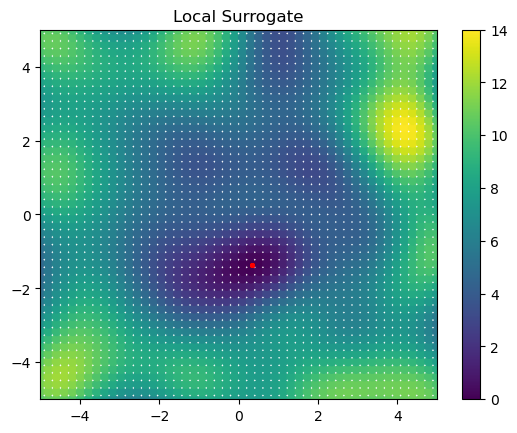

Generation 200: Best RBF Fitness = [3.42001934]
[False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False]
[22]


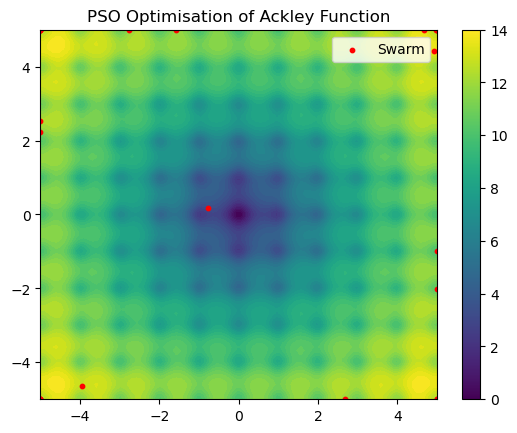

Iteration 4: Best Fitness = 4.219309861732029


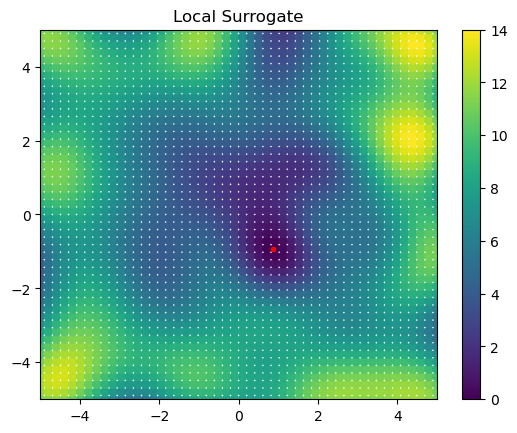

Generation 200: Best RBF Fitness = [4.08954548]
[False False False  True False False False False False  True False False
 False False False False False False  True False False False False False
 False]
[ 3  9 18]


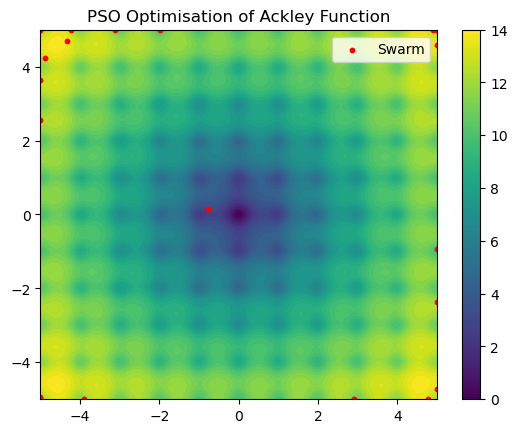

Iteration 5: Best Fitness = 3.801496063490966


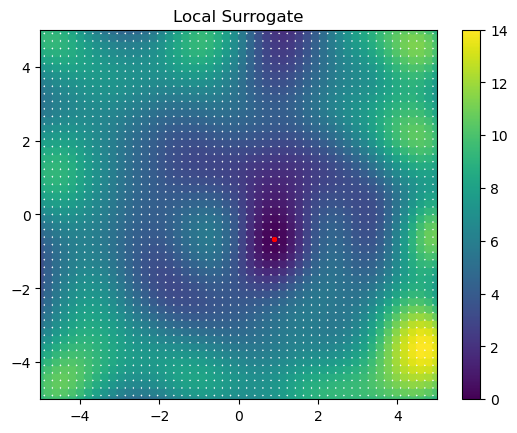

Generation 200: Best RBF Fitness = [3.65449964]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
[]


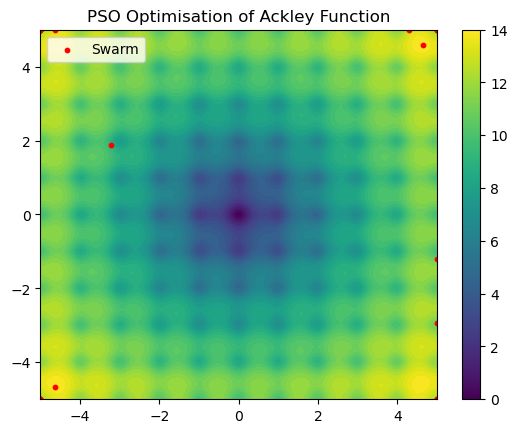

Iteration 6: Best Fitness = 3.801496063490966


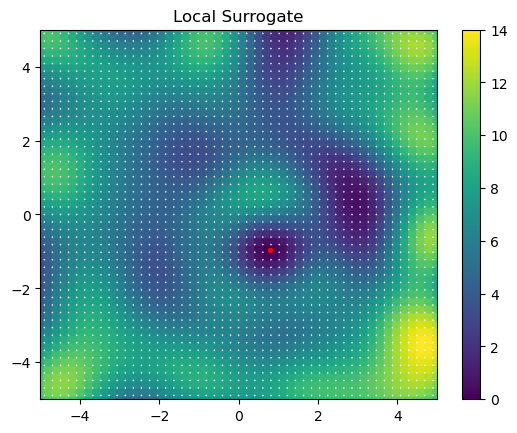

Generation 200: Best RBF Fitness = [3.76459976]
[False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False]
[9]


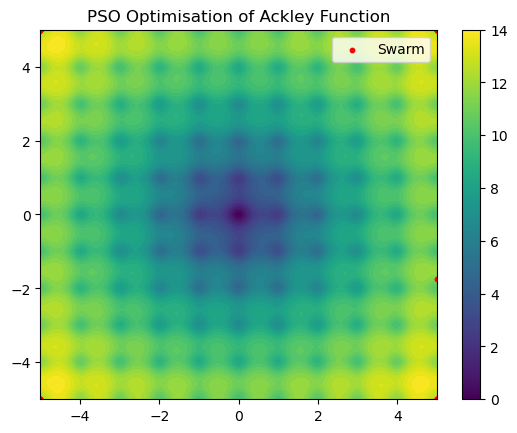

Iteration 7: Best Fitness = 3.801496063490966


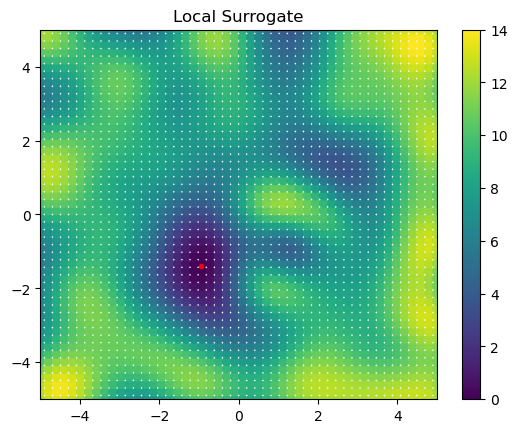

Generation 200: Best RBF Fitness = [-1.88388972]
[False False False False False False False False False  True False False
 False False False False False False False False False False  True False
 False]
[ 9 22]


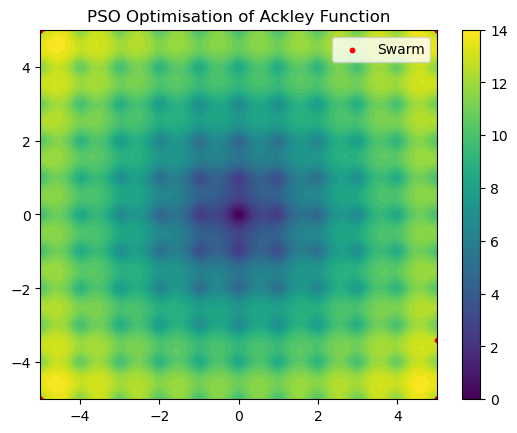

Iteration 8: Best Fitness = 3.801496063490966


KeyboardInterrupt: 

In [151]:
bounds = [(-5,5), (-5,5)] #bounds for each dimension (x and y)

PSO = PSOPrescreen(bounds, 25)

PSO.optimise()